## Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [234]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score

In [307]:
# вывод значения p_value, графиков ряда и графиков автокорелляции и частичной автокорелляции
def plot_ts(series):
    plt.figure(figsize=(14, 5))
    adf_test = adfuller(series)
    print('p-value = ' +str(adf_test[1]))
    plt.plot(series)
    plt.show()
    plot_acf(series)
    plt.show()
    plot_pacf(series)
    plt.show()
    
    
# определение оптимального значения лага, при котором минимален p_value для сезонного дифференцирования
def minimisation(series, cycle):
    pv = 1
    for i in range(1, cycle):
        series_ = series[i:] -series[:-i]
        adf_test = adfuller(series_)
        #print('p_value:'+str(adf_test[1]))
        if adf_test[1] < pv:
            pv = adf_test[1]
            li = i
        else:
            pass
    
    return li, pv


# дифференцирование
def diff(series, lag):
    series_n = series[lag:] - series[:-lag]
    return series_n

In [17]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [175]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

In [92]:
def mse_dema(X):
    alpha, beta = X
    series = np.concatenate((train, test))
    result = double_ema(series, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [287]:
dowjones = pd.read_csv('Series/weekly-closings-of-the-dowjones-.csv')

In [288]:
dowjones = dowjones['Close']

### 1. Нестационарный ряд

p-value = 0.6224548515589717


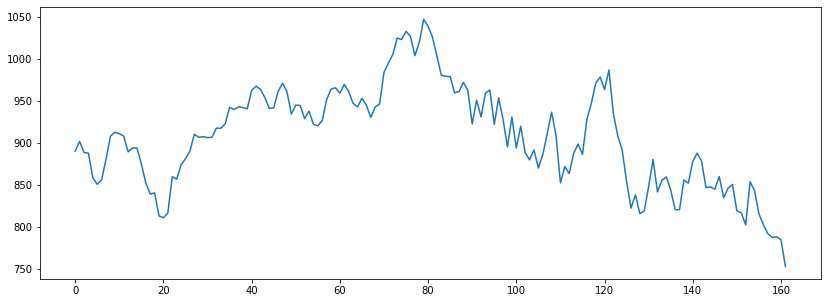

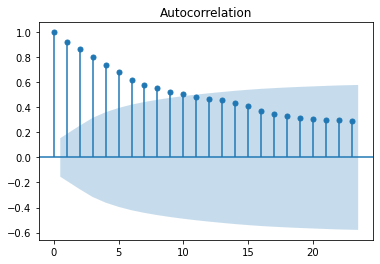

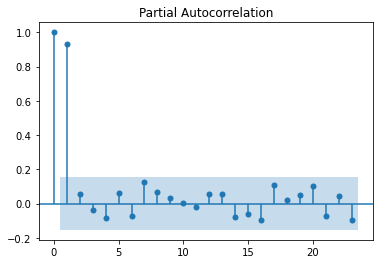

In [308]:
plot_ts(dowjones)

Ряд имеет тренд, но нет сезонности. Можно применить модель DEMA

Разобьем ряд на train(80%), test(20)

In [290]:
train = dowjones[:int(0.8*len(dowjones))]
test = dowjones[(int(0.8*len(dowjones)) - len(dowjones)):]

In [291]:
opt = minimize(mse_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [292]:
print(opt)

      fun: 0.19031002884209422
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.88380429e-06,  3.57769370e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 20
     njev: 22
   status: 0
  success: True
        x: array([0.98866538, 0.015978  ])


In [293]:
alpha, beta, n_preds = opt.x[0], opt.x[1], len(test)

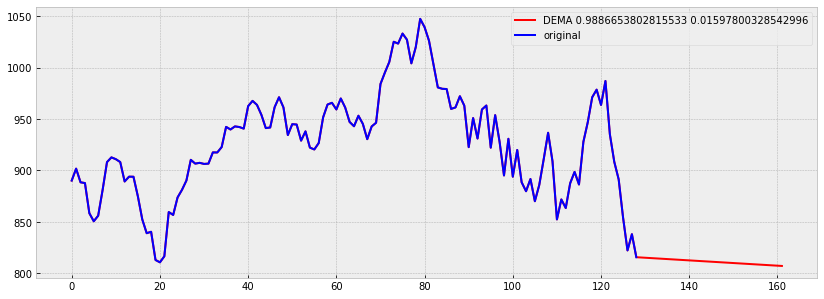

In [294]:
alphas = [alpha]
bettas = [beta]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(train, alphas[i], bettas[i], n_preds)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(train, color='blue',label='original')
    plt.legend()

In [295]:
predicted = double_ema_with_preds(train, alpha, beta, n_preds)[0]
predicted_y = predicted[-len(test):]

In [296]:
np.sqrt(mean_squared_error(test, predicted_y)) #среднеквадратичное отклонение предсказанных данных от тестовых

37.345447211784865

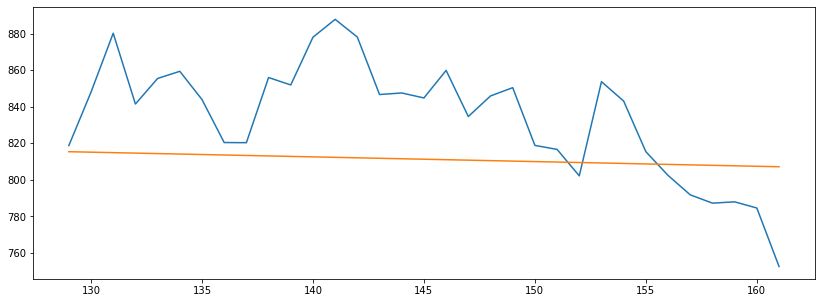

In [297]:
plt.figure(figsize=(14, 5))
plt.plot(test)
plt.plot(predicted_y)

### 2. Стационарный ряд

Для стационарного ряда подходит модель EMA

In [309]:
dowjones_b = boxcox(dowjones, 0)

In [310]:
dowjones_d = diff(dowjones_b, 1)

p-value = 2.751609132291384e-24


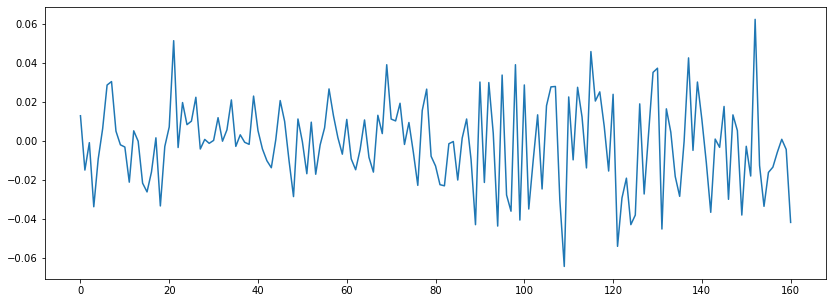

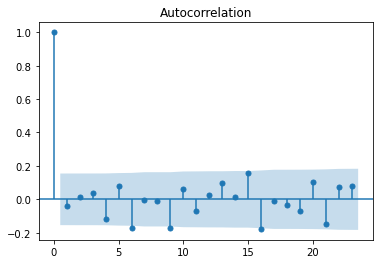

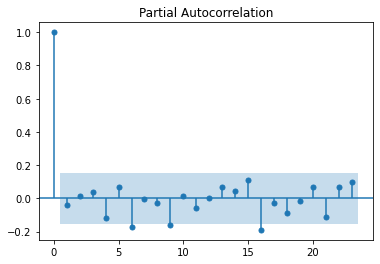

In [311]:
plot_ts(dowjones_d) #вывод стационарного ряда

In [328]:
dowjones_pd = pd.DataFrame(dowjones_d)

In [335]:
train = dowjones_pd[:int(0.8*len(dowjones_pd))]
test = dowjones_pd[(int(0.8*len(dowjones_pd)) - len(dowjones_pd)):]

In [384]:
def ema_pred(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

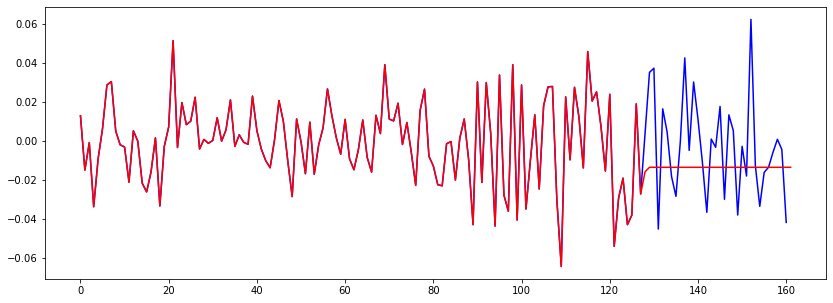

In [385]:
plt.figure(figsize=(14,5))
plt.plot(dowjones_pd, color='blue')
plt.plot(ema_pred(train[0], 0.2, 33)[0], color='red')

In [404]:
predicted = ema_pred(train[0], 0.2, 33)[0]

In [405]:
predicted_y = predicted[-len(test):]

In [406]:
np.sqrt(mean_squared_error(test[0], predicted_y)) #среднеквадратичное отклонение предсказанных данных от тестовых

0.027388808013734327

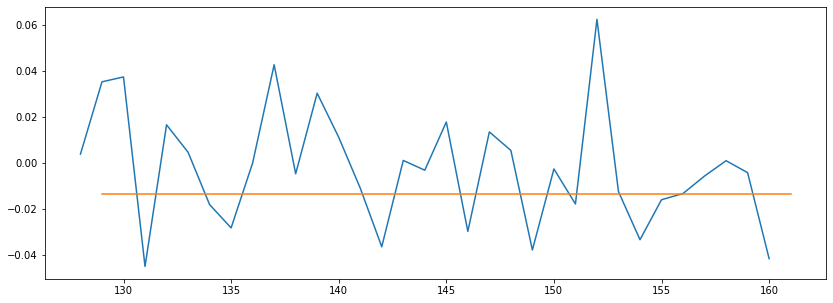

In [407]:
plt.figure(figsize=(14, 5))
plt.plot(test)
plt.plot(predicted_y)